In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt          # plotting
from scipy.sparse import csr_matrix      # sparse matrices
%matplotlib inline

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [4]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [5]:
# now we can load it back
import json
with open('people_wiki_map_index_to_word.json','r') as f:
    map_index_to_word = json.load(f)

In [6]:
from sklearn.preprocessing import normalize

In [7]:
tf_idf = normalize(tf_idf)

In [8]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [9]:
from sklearn.metrics.pairwise import pairwise_distances
# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print dist

[[ 1.41000789  1.36894636]
 [ 1.40935215  1.41023886]
 [ 1.39855967  1.40890299]
 ..., 
 [ 1.41108296  1.39123646]
 [ 1.41022804  1.31468652]
 [ 1.39899784  1.41072448]]


In [10]:
dist.shape, tf_idf.shape

((59071, 2), (59071, 547979))

In [14]:
# Get the TF-IDF vectors for documents 100 through 102.
query = tf_idf[:3,:]
all_dist = pairwise_distances(tf_idf, query, metric='euclidean')

In [15]:
all_dist.shape

(59071, 3)

In [16]:
print all_dist

[[ 0.          1.40775177  1.38784582]
 [ 1.40775177  0.          1.39867641]
 [ 1.38784582  1.39867641  0.        ]
 ..., 
 [ 1.37070999  1.40978937  1.40616385]
 [ 1.35214578  1.41306211  1.40869799]
 [ 1.40799024  1.41353429  1.40903605]]


In [21]:
all_dist[430,1], pairwise_distances(tf_idf[430,:], tf_idf[1,:])

(1.4071310658540346, array([[ 1.40713107]]))

In [22]:
dist = all_dist[430,1]

In [23]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [27]:
closest_cluster = np.argmin(all_dist, axis=1)

In [28]:
all_dist.shape, closest_cluster.shape

((59071, 3), (59071,))

In [30]:
closest_cluster

array([0, 1, 2, ..., 0, 0, 0])

In [31]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in all_dist]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [33]:
'''Test cluster assignment'''
if len(closest_cluster)==59071 and \
   np.array_equal(np.bincount(closest_cluster), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [34]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis=1)
    
    return cluster_assignment

In [35]:
''' Test function '''
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


In [36]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])
cluster_assignment = assign_clusters(data, centroids)
print cluster_assignment   # prints [0 1 0]
print data[cluster_assignment==1]
print data[cluster_assignment==0]

[0 1 0]
[[ 0.  0.  0.]]
[[ 1.  2.  0.]
 [ 2.  2.  0.]]


In [45]:
cluster_assignment

array([0, 1, 0])

In [37]:
print data[cluster_assignment==0].mean(axis=0)

[ 1.5  2.   0. ]


In [40]:
print data[cluster_assignment==1].mean(axis=0)

[ 0.  0.  0.]


In [84]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [46]:
ca = np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])
ca

array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])

In [49]:
tf_idf[0:100:10].shape, tf_idf.shape

((10, 547979), (59071, 547979))

In [55]:
tf_idf[0:100:10][ca==0].mean(axis=0).shape, tf_idf[0:100:10][ca==1].mean(axis=0).shape, tf_idf[0:100:10][ca==2].mean(axis=0).shape

((1, 547979), (1, 547979), (1, 547979))

In [59]:
x1 = tf_idf[0:100:10][ca==0]
x2 = tf_idf[0:100:10][ca==1]
x3 = tf_idf[0:100:10][ca==2]

In [61]:
x1.mean(axis=0), x2.mean(axis=0), x3.mean(axis=0)

(matrix([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            1.50008938e-04,   8.46265596e-05,   2.38278645e-05]]),
 matrix([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            8.72572638e-05,   6.98529765e-05,   1.99263190e-05]]),
 matrix([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
            1.01598466e-04,   8.08230804e-05,   1.77362711e-05]]))

In [85]:
result = revise_centroids(tf_idf[:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [86]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [87]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [88]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

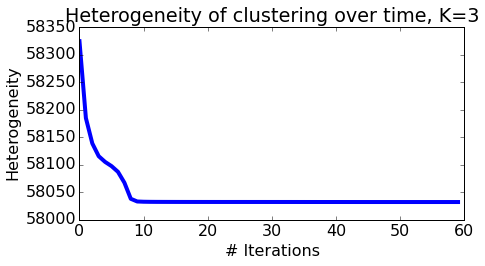

In [89]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [92]:
centroids

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.13957629e-04,   9.38937922e-05,   1.98350206e-05],
       [  0.00000000e+00,   9.46593597e-06,   0.00000000e+00, ...,
          1.37670861e-04,   6.49631597e-05,   2.27433941e-05],
       [  4.92624714e-06,   0.00000000e+00,   4.72954750e-06, ...,
          1.09191883e-04,   8.63979609e-05,   2.07849580e-05]])

In [97]:
cluster_assignment.shape, centroids.shape

((59071,), (3, 547979))

In [95]:
np.bincount(cluster_assignment)

array([19595, 10427, 29049])

In [96]:
cluster_assignment

array([1, 2, 0, ..., 1, 1, 2])

In [99]:
centroids

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.13957629e-04,   9.38937922e-05,   1.98350206e-05],
       [  0.00000000e+00,   9.46593597e-06,   0.00000000e+00, ...,
          1.37670861e-04,   6.49631597e-05,   2.27433941e-05],
       [  4.92624714e-06,   0.00000000e+00,   4.72954750e-06, ...,
          1.09191883e-04,   8.63979609e-05,   2.07849580e-05]])

In [100]:
centroids.shape[1]/centroids.shape[0]

182659

Beware of local minima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

Note: Again, in practice, you should set different seeds for every run. We give you a list of seeds for this assignment so that everyone gets the same answer.

In [102]:
k = 10
heterogeneity = {}
import time
import sys
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
seed=020000, heterogeneity=57533.20100
seed=040000, heterogeneity=57512.69257
seed=060000, heterogeneity=57466.97925
seed=080000, heterogeneity=57494.92990
seed=100000, heterogeneity=57484.42210
seed=120000, heterogeneity=57554.62410
300.845809221


In [107]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in xrange(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

In [108]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
380.904027939


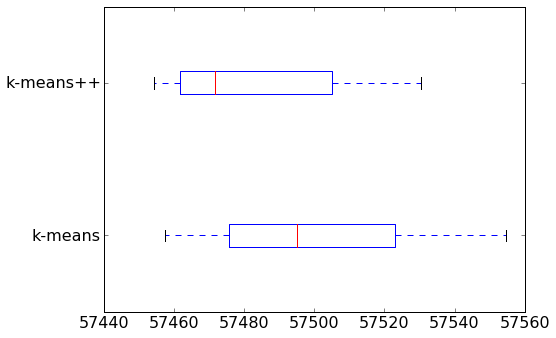

In [109]:
plt.figure(figsize=(8,5))
plt.boxplot([heterogeneity.values(), heterogeneity_smart.values()], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

A few things to notice from the box plot:

On average, k-means++ produces a better clustering than Random initialization.
Variation in clustering quality is smaller for k-means++.
In general, you should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity. Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [111]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in xrange(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids = smart_initialize(data, k, seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, verbose=verbose)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

In [112]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

2
10
25
50
100


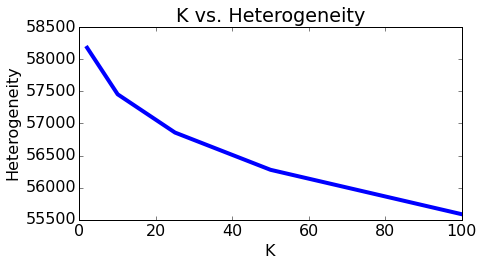

In [114]:
import os

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print k
        sys.stdout.flush()
        centroids[k] = arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_assignment[k])
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

In [174]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in xrange(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        print idx[:5]
        for i in xrange(5): # Print each word along with the TF-IDF weight
            #print idx[i]
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, [centroids[c]], metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in xrange(8):
                #print nearest_neighbors[i]
                text = ' '.join(wiki.ix[nearest_neighbors[i],['text']].str[:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.ix[nearest_neighbors[i],['name']],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [175]:
inv_map = {v: k for k, v in map_index_to_word.iteritems()}
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_assignment[2], 2, inv_map)

Cluster 0     [547896 547903 547870 547966 547954]
she:0.025 her:0.017 music:0.012 he:0.011 university:0.011 

* name    Anita Kunz
Name: 37198, dtype: object      0.97401
  anita e kunz oc born 1956
  

* name    Janet Jackson
Name: 54350, dtype: object   0.97472
  janet damita jo jackson b
  

* name    Madonna (entertainer)
Name: 40505, dtype: object 0.97475
  madonna louise ciccone tk
  

* name    %C3%81ine Hyland
Name: 13497, dtype: object 0.97536
  ine hyland ne donlon is e
  

* name    Jane Fonda
Name: 11666, dtype: object      0.97621
  jane fonda born lady jayn
  

* name    Christine Robertson
Name: 5205, dtype: object 0.97643
  christine mary robertson 
  

* name    Pat Studdy-Clift
Name: 26909, dtype: object 0.97643
  pat studdyclift is an aus
  

* name    Alexandra Potter
Name: 28487, dtype: object 0.97646
  alexandra potter born 197
  
Cluster 1     [547809 547856 547876 547651 547904]
league:0.040 season:0.036 team:0.029 football:0.029 played:0.028 

* name    Todd W

In [126]:
inv_map[547896]

u'she'

In [165]:
wiki.ix[37198,['text']].str.split(' ')[:25]

text    [anita, e, kunz, oc, born, 1956, is, a, canadi...
dtype: object

In [161]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [176]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_assignment[k], k, inv_map)

Cluster 0     [547818 547693 547966 547827 547828]
film:0.020 art:0.014 he:0.011 book:0.010 television:0.010 

* name    Wilson McLean
Name: 37815, dtype: object   0.97479
  wilson mclean born 1937 i
  

* name    Anton Hecht
Name: 934, dtype: object       0.97748
  anton hecht is an english
  

* name    David Salle
Name: 27250, dtype: object     0.97800
  david salle born 1952 is 
  

* name    Vipin Sharma
Name: 32393, dtype: object    0.97805
  vipin sharma is an indian
  

* name    Paul Swadel
Name: 50025, dtype: object     0.97823
  paul swadel is a new zeal
  

* name    Allan Stratton
Name: 36172, dtype: object  0.97834
  allan stratton born 1951 
  

* name    Bill Bennett (director)
Name: 58179, dtype: object 0.97848
  bill bennett born 1953 is
  

* name    Rafal Zielinski
Name: 50978, dtype: object 0.97850
  rafal zielinski born 1957
  
Cluster 1     [547809 546442 547780 547608 547856]
league:0.052 rugby:0.044 club:0.042 cup:0.042 season:0.041 

* name    Chris Day
Name: 

In [177]:
tf_idf.shape

(59071, 547979)

In [178]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_assignment[25], 25,
                            inv_map, display_content=False) 

Cluster 0     [547685 547550 547479 546946 547146]
law:0.077 district:0.048 court:0.046 republican:0.038 senate:0.038 
Cluster 1     [547784 547824 547734 547954 546266]
research:0.054 professor:0.033 science:0.032 university:0.031 physics:0.029 
Cluster 2     [546289 545222 546386 547856 547809]
hockey:0.216 nhl:0.134 ice:0.065 season:0.052 league:0.047 
Cluster 3     [547729 547647 547768 547207 547942]
party:0.065 election:0.042 elected:0.031 parliament:0.027 member:0.023 
Cluster 4     [547775 547866 547621 547720 547677]
board:0.025 president:0.023 chairman:0.022 business:0.022 executive:0.020 
Cluster 5     [547563 547092 546715 547729 547647]
minister:0.160 prime:0.056 cabinet:0.044 party:0.043 election:0.042 
Cluster 6     [547954 547824 547736 547797 546959]
university:0.044 professor:0.037 studies:0.035 history:0.034 philosophy:0.031 
Cluster 7     [547647 544342 546827 547729 546067]
election:0.066 manitoba:0.058 liberal:0.051 party:0.045 riding:0.043 
Cluster 8     [546629 